Most of this code is modified from Daniel Kennedy's code for parameter selection (on Github; https://github.com/djk2120/CLM5PPE/blob/master/pyth/param_selection.ipynb) 

# Set up workspace

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
#from altair import datum

# Define functions for reading in PPE data
(code from Daniel Kennedy)

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    """Code from Daniel Kennedy"""
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='UWAS0044', # Input your project ID here
        walltime='1:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient()
cluster.scale(20)

In [4]:
client

Client Scheduler: tcp://10.12.206.63:37599 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/czarakas/proxy/{port}/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
def get_params(keys,paramkey):
    """Code from Daniel Kennedy"""
    params=[]
    minmaxs=[]
    for key in keys:
        ix     = paramkey.key==key
        params.append(paramkey.param[ix].values[0])
        minmaxs.append(paramkey.minmax[ix].values[0])
    return params,minmaxs

In [6]:
def month_wts(nyears):
    """Code from Daniel Kennedy"""
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [7]:
def get_ensemble(name,data_vars,htape,keys,paramkey):
    """Code from Daniel Kennedy"""
    '''
    Returns a dataset comprising the given ensemble
    name  = 'CTL2020' or 'C285' or 'AF1905'
    data_vars, e.g. ['GPP','HR','AR']
    htape, e.g. 'h0' 0/1/2/3/4/5/7 available
    '''
    
    #define the directory structure and find files
    topdir     = '/glade/scratch/djk2120/PPEn11/hist/' 
    thisdir    = topdir+name+'/'
    files      = [glob.glob(thisdir+'*'+key+'*'+htape+'*.nc')[0] for key in keys]

    def preprocess(ds):
        return ds[data_vars]

    #read in the dataset
    ds = xr.open_mfdataset(files,combine='nested',concat_dim='ens',
                           parallel=True,preprocess=preprocess)

    #fix up time dimension
    if htape=='h0':
        ds['time'] = xr.cftime_range(str(2005),periods=120,freq='MS') #fix time bug
    
    #add in some extra variables
    ds0 = xr.open_dataset(files[0])
    extras = ['grid1d_lat','grid1d_lon']
    for extra in extras:
        ds[extra]=ds0[extra]

    #append some info about key/param/minmax
    params,minmaxs = get_params(keys,paramkey) 
    ds['key']    = xr.DataArray(keys,dims='ens')
    ds['param']  = xr.DataArray(params,dims='ens')
    ds['minmax'] = xr.DataArray(minmaxs,dims='ens')
    
    whit         = xr.open_dataset('./whit/whitkey.nc') #('./whit/whitkey2.nc')
    ds['biome']      = whit['biome']
    ds['biome_name'] = whit['biome_name']
    
    return ds

In [8]:
def calc_mean(ds,datavar):
    """Code modified from code from Daniel Kennedy"""
    cf = cfs[datavar]
    x  = ds[datavar]
    
    da_ann  = cf*(month_wts(10)*(la*x).sum(dim='gridcell')).groupby('time.year').sum(dim='time').compute()
    da_mean = da_ann.mean(dim='year') 
    
    return da_mean,da_ann

In [9]:
def calc_iav(ds,datavar,da_ann=[]):
    """Code modified from code from Daniel Kennedy"""
    #compute da_ann if not provided
    if len(da_ann)==0:
        cf = cfs[datavar]
        x  = ds[datavar]
        da_ann  = cf*(month_wts(10)*(la*x).sum(dim='gridcell')).groupby('time.year').sum().compute()
    da_iav = da_ann.std(dim='year')
    return da_iav

In [10]:
def top_n(da,nx,params,minmax,uniques):
    """ Code from Daniel Kennedy """
    xmins=[];xmaxs=[];dxs=[]
    for u in uniques:
        pair  = find_pair(da,params,minmax,u)
        xmin  = pair[0].values
        xmax  = pair[1].values
        dx    = abs(xmax-xmin)

        xmins.append(xmin)
        xmaxs.append(xmax)
        dxs.append(dx)

    ranks = np.argsort(dxs)

    pvals = [uniques[ranks[i]] for i in range(-nx,0)]
    xmins = [xmins[ranks[i]]   for i in range(-nx,0)]
    xmaxs = [xmaxs[ranks[i]]   for i in range(-nx,0)]
    
    return xmins,xmaxs,pvals

In [11]:
def find_pair(da,params,minmax,p):
    '''
    Code from Daniel Kennedy
    returns a subset of da, corresponding to parameter-p
        the returned pair corresponds to [p_min,p_max]
    '''
    ixmin = np.logical_and(params==p,minmax=='min')
    ixmax = np.logical_and(params==p,minmax=='max')
    
    #sub in default if either is missing
    if ixmin.sum().values==0:
        ixmin = params=='default'
    if ixmax.sum().values==0:
        ixmax = params=='default'
        
    emin = da.ens.isel(ens=ixmin).values[0]
    emax = da.ens.isel(ens=ixmax).values[0]

    return da.sel(ens=[emin,emax])

In [12]:
def plot20(da,nx,tstr,ll=True,xstr=''):
    
    uniques = list(np.unique(ds.param))
    uniques.remove('default')
    
    xmins,xmaxs,pvals = top_n(da,nx,params,minmax,uniques)
    xdef = da.isel(ens=0)
    unit = da.attrs['units']
    

    
    if len(xstr)==0:
        xstr=tstr
    nx = len(pvals)
    plt.plot([xdef,xdef],[0,nx-1],'k:',label='default')
    plt.scatter(xmins,range(nx),marker='o',facecolors='none', edgecolors='r',label='low-val')
    plt.plot(xmaxs,range(nx),'ro',label='high-val')
    if ll:
        plt.legend(loc=3)
    i=-1
    for xmin,xmax in zip(xmins,xmaxs):
        i+=1
        plt.plot([xmin,xmax],[i,i],'r')
    plt.yticks(range(nx),pvals)
    plt.title(tstr)
    plt.xlabel(xstr+' ('+unit+')');

# Read in Data

In [13]:
#fetch the paraminfo
csv = '/glade/scratch/djk2120/PPEn11/firstpass.csv' 
paramkey = pd.read_csv(csv)

#fetch the sparsegrid landarea
la_file = '/glade/scratch/djk2120/PPEn08/sparsegrid_landarea.nc'
la = xr.open_dataset(la_file).landarea  #km2

In [14]:
#choose your subset of variables
data_vars = ['FIRE','FSA','FSDSVD','FSRVD','FSDSND', 'FSRND','FSDSVI', 'FSRVI','FSDSNI', 'FSRNI',
             'FSR','FSDS','EFLX_LH_TOT','FSH',
             'QVEGT','QVEGE','QSOIL',
             'TSA','TSKIN',
             'Q2M',
             'TAUX','TAUY','U10']

keys = paramkey.key

#read in the dataset
ds = get_ensemble('CTL2010',data_vars,'h0',keys,paramkey)

In [15]:
uniques = np.unique(ds.param)
ix = uniques=='default'
uniques = uniques[~ix]

### Calculate new variables

In [16]:
ds['albedo_allSW'] = ds['FSR']/ds['FSDS']
ds['albedo_allSW'].attrs['units']='unitless'
ds['alb_DirVis'] = ds['FSRVD']/ds['FSDSVD']
ds['alb_DirVis'].attrs['units']='unitless'
ds['alb_DirNIR'] = ds['FSRND']/ds['FSDSND']
ds['alb_DirNIR'].attrs['units']='unitless'
ds['alb_DifVis'] = ds['FSRVI']/ds['FSDSVI']
ds['alb_DifVis'].attrs['units']='unitless'
ds['alb_DifNIR'] = ds['FSRNI']/ds['FSDSNI']
ds['alb_DifNIR'].attrs['units']='unitless'

ds['ET'] = ds['QVEGT']+ds['QVEGE']+ds['QSOIL']
ds['ET'].attrs['units']=ds['QVEGT'].attrs['units']

In [17]:
data_vars2 = ['EFLX_LH_TOT',
              'FSH',
              'ET',
              'TAUX',
              'TAUY',
              'FIRE',
              'alb_DirVis',
              'alb_DifVis',
              'alb_DirNIR',
              'alb_DifNIR',
              'FSA',
              'TSKIN',
              'TSA',
              'Q2M',
              'U10']

In [18]:
cfs = dict()             # Conversion Factors
units = dict()
lasum = la.sum().values
    
for field in data_vars2:
    #intensives (need to account for landarea)
    cfs[field]   = 1/la.sum()/365
    units[field] = ds[field].attrs['units']

# Biome by Biome analysis

In [19]:
env = 'CTL2010'
#@njit
def calc_mean_biome(dsb,datavar,lab):

    domain='biome'
    preload = './data/'+env+'_'+datavar+'_'+domain+'.nc'
    
    if not glob.glob(preload):
        #do the calculation
        cf = cfs[datavar]  #conversion factor
        if cf=='intrinsic':
            cf = 1/lab.groupby('biome').sum()/365
        x  = dsb[datavar]

        #calc annual mean or sum (determined by cf)
        xann = cf*(month_wts(10)*(lab*x).groupby('biome').sum()).groupby('time.year').sum().compute()

        #average/iav
        xm  = xann.mean(dim='year') 
        iav = xann.std(dim='year')

        #save the reduced data
        out = xr.Dataset()
        out[datavar+'_mean'] = xm
        out[datavar+'_mean'].attrs= {'units':units[datavar]}
        out[datavar+'_iav']  = iav
        out[datavar+'_iav'].attrs= {'units':units[datavar]}
        out['param']  = dsb.param
        out['minmax'] = dsb.minmax
        out.load().to_netcdf(preload)


    #load from file if available
    ds  = xr.open_dataset(preload)
    xm  = ds[datavar+'_mean']
    iav = ds[datavar+'_iav']
    
    return xm,iav

In [20]:
params = ds.param
minmax = ds.minmax

In [21]:
la['biome']=ds['biome']
lab = la.swap_dims({'gridcell':'biome'})
dsb = ds.swap_dims({'gridcell':'biome'})

In [22]:
cutoff_num =5
params_top5 = []
params_biome = []
params_criteria = []
params_rank = []
for datavar in data_vars2:
    #print(datavar)
    da,iav = calc_mean_biome(dsb,datavar,lab)
    #print('calculated')
    
    da,iav = calc_mean_biome(dsb,datavar,lab)
    uniques = list(np.unique(ds.param))
    uniques.remove('default')
    
    for i in np.arange(0,10):
        #print(i)
        [xmins,xmaxs,pvals] = top_n(da.isel(biome=i),
                                    10,params,minmax,uniques)
        b = str(dsb.biome_name.isel(biome_id=i).values)
        pvals.reverse()
        xmins.reverse()
        xmaxs.reverse()
        params_top5 = params_top5 + pvals[0:cutoff_num]
        params_biome = params_biome+[b]*cutoff_num
        params_criteria = params_criteria+[da.name+'_'+b]*cutoff_num
        params_rank = params_rank+np.arange(1,cutoff_num+1).tolist()
        
        #print(pvals[0:5])

In [23]:
# dictionary of lists 
df_biomes = pd.DataFrame({'param_name': params_top5, 
        'biome': params_biome, 
        'criteria': params_criteria, 
        'rank': params_rank} )

(45,)


lmrse                           81
jmaxb0                          70
lmrhd                           65
medlynintercept                 37
vcmaxse_sf                      33
vcmaxha                         32
zetamaxstable                   30
jmaxse_sf                       28
zsno                            27
tpuha                           26
taulnir                         25
rhosnir                         22
rholnir                         21
fff                             21
medlynslope                     20
sucsat_sf                       19
snw_rds_refrz                   16
z0mr                            16
d_max                           15
upplim_destruct_metamorph       14
bsw_sf                          13
wc2wjb0                         12
zlnd                            11
nstem                           11
kmax                            11
maximum_leaf_wetted_fraction    11
slopebeta                       11
rholvis                          9
watsat_sf           

### Make figures for just one variable

In [42]:
datavar = 'FSH'
da,iav = calc_mean_biome(dsb,datavar,lab)

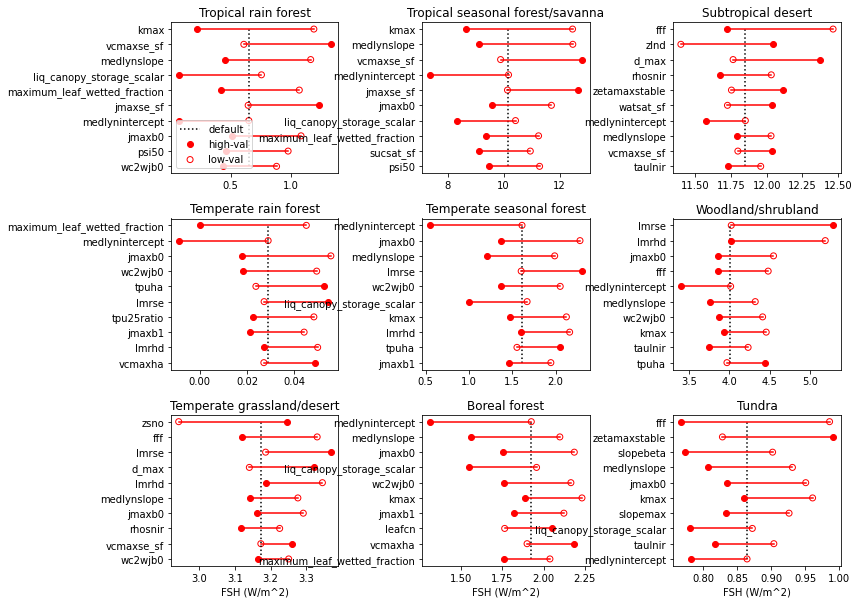

In [43]:
### exclude ice sheet
plt.figure(figsize=[12,10])
ll=True
for i in 1+np.arange(9):
    plt.subplot(3,3,i)
    
    b = str(dsb.biome_name.isel(biome_id=i).values)
    
    plot20(da.isel(biome=i),10,b,ll=ll,xstr=datavar)
    ll=False
    if i<7:
        plt.xlabel('')
        
plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=0.5)

# Analysis: global mean and interannual variability

In [33]:
cutoff_num =5
params_top5 = []
params_biome = []
params_criteria = []
params_rank = []

uniques = list(np.unique(ds.param))
uniques.remove('default')

for datavar in data_vars2:
    print(datavar)
    [da_mean,da_ann] = calc_mean(ds, datavar)
    iav = calc_iav(ds, datavar, da_ann=da_ann)
    
    # Mean
    [xmins,xmaxs,pvals] = top_n(da_mean,
                                cutoff_num,params,minmax,uniques)
    pvals.reverse()
    xmins.reverse()
    xmaxs.reverse()
    params_top5 = params_top5 + pvals[0:cutoff_num]
    params_biome = params_biome+['global']*cutoff_num
    params_criteria = params_criteria+[datavar+'_MEAN_global']*cutoff_num
    params_rank = params_rank+np.arange(1,cutoff_num+1).tolist()

    # IAV
    [xmins,xmaxs,pvals] = top_n(iav,cutoff_num,params,minmax,uniques)
    pvals.reverse()
    xmins.reverse()
    xmaxs.reverse()
    params_top5 = params_top5 + pvals[0:cutoff_num]
    params_biome = params_biome+['global']*cutoff_num
    params_criteria = params_criteria+[datavar+'_IAV_global']*cutoff_num
    params_rank = params_rank+np.arange(1,cutoff_num+1).tolist()

EFLX_LH_TOT
FSH
ET
TAUX
TAUY
FIRE
alb_DirVis
alb_DifVis
alb_DirNIR
alb_DifNIR
FSA
TSKIN
TSA
Q2M
U10


In [34]:
# dictionary of lists 
df_global = pd.DataFrame({'param_name': params_top5, 
        'biome': params_biome, 
        'criteria': params_criteria, 
        'rank': params_rank} )

# Combine all criteria

In [35]:
df_all = pd.concat([df_biomes, df_global], ignore_index=True)

In [47]:
print(np.shape(df_all['param_name'].value_counts()))
print(np.shape(df_all['param_name'][df_all['rank']<=5].value_counts()))
df_all['param_name'][df_all['rank']<=5].value_counts()

(48,)
(48,)


lmrse                           98
jmaxb0                          86
lmrhd                           77
vcmaxse_sf                      50
medlynintercept                 42
jmaxse_sf                       42
vcmaxha                         34
zetamaxstable                   32
zsno                            28
taulnir                         28
tpuha                           27
fff                             26
rholnir                         26
rhosnir                         25
medlynslope                     23
sucsat_sf                       23
d_max                           22
z0mr                            20
kmax                            17
wc2wjb0                         16
snw_rds_refrz                   16
nstem                           14
upplim_destruct_metamorph       14
maximum_leaf_wetted_fraction    13
bsw_sf                          13
rholvis                         12
slopebeta                       11
zlnd                            11
frac_sat_soil_dsl_in

In [108]:
var = 'xl'
print(np.shape(df_all[df_all['param_name']==var])[0])
df_all[df_all['param_name']==var]

3


,param_name,biome,criteria,rank
309,xl,Tropical rain forest,alb_DirVis_mean_Tropical rain forest,5
359,xl,Tropical rain forest,alb_DifVis_mean_Tropical rain forest,5
409,xl,Tropical rain forest,alb_DirNIR_mean_Tropical rain forest,5


# Other functions / code (NOT USED)

In [25]:
def calc_alt(ds):
    """Code from Daniel Kennedy"""
    cf   = cfs['ALTMAX']
    ix   = ds.ALTMAX.isel(ens=0).mean(dim='time')<10
    xann = cf*(la*ds.ALTMAX.where(ix).groupby('time.year').max()).sum(dim='gridcell').compute()
    xm   = xann.mean(dim='year')
    xi   = xann.std(dim='year')
    return xm,xi

In [27]:
def twoplots(ds,datavar,xm,xi,uniques):
    plt.subplot(121)
    xdef  = xm.isel(ens=0)
    xmins,xmaxs,pm = top_n(xm,nx,ds.param,ds.minmax,uniques)
    plot20(datavar,xdef,xmins,xmaxs,pm,'mean',units[datavar])

    plt.subplot(122)
    xdef  = xi.isel(ens=0)
    xmins,xmaxs,pi = top_n(xi,nx,ds.param,ds.minmax,uniques)
    plot20(datavar,xdef,xmins,xmaxs,pi,'IAV',units[datavar])


    plt.subplots_adjust(wspace=0.8)
    plt.subplots_adjust(left=0.22) 

    ln =ds[datavar].attrs['long_name'].capitalize()
    if len(ln)<100:
        plt.figtext(0.562,0.95,ln,fontsize=12,ha='center')
    else:
        i = int(len(ln)/2)
        ln1 = ln[:i]
        ln2 = ln[i:]
        plt.figtext(0.562,0.98,ln1,fontsize=12,ha='center')
        plt.figtext(0.562,0.94,ln2,fontsize=12,ha='center')
        
    return pm,pi

alb_DirVis


NameError: name 'nx' is not defined

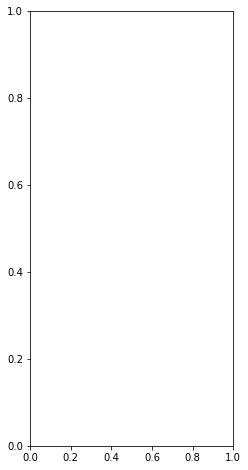

In [26]:
cts      = {u:0 for u in uniques}
ct_means = {u:0 for u in uniques}
ct_iavs  = {u:0 for u in uniques}

for datavar in data_vars2:
    print(datavar)
    if datavar=='ALTMAX':
        xm,xi = calc_alt(ds)
    else:
        xm,xa = calc_mean(ds,datavar)
        xi    = calc_iav(0,0,xa)

    plt.figure(figsize=[8,8])
    pm,pi = twoplots(ds,datavar,xm,xi,uniques)
    #plt.savefig('../figs/'+datavar+'_top20.pdf')
    plt.close("all")
    
    for p in pm:
        cts[p]+=1
        ct_means[p]+=1

    for p in pi:
        cts[p]+=1
        ct_iavs[p]+=1

In [ ]:
pcts=sorted(cts.items(), key=lambda item: item[1])
pvals=[];ct0=[];ct1=[]
for p,x in pcts:
    
    if x==0:
        pvals.append(p)
        ct0.append(ct_means[p])
        ct1.append(ct_iavs[p])
    else:
        pvals.insert(0,p)
        ct0.insert(0,ct_means[p])
        ct1.insert(0,ct_iavs[p])
    
ct_table = pd.DataFrame({'param':pvals,'mean':ct0,'iav':ct1})
ct_table.to_html(buf='top20_summary.html')

In [ ]:
## make a summary table
nx = 20
ctmeans = dict()
ctiavs  = dict()

for datavar in data_vars:
    print(datavar)
    cf      = cfs[datavar]

    xmeans,xiavs,xann = param_effect(ds,datavar,cf,uniques,da=[])

    topx,pvals = top_n(xmeans,uniques,nx)
    for p in pvals:
        if p not in ctmeans:
            ctmeans[p]=1
        else:
            ctmeans[p]=1+ctmeans[p]

    topx,pvals = top_n(xiavs,uniques,nx)
    for p in pvals:
        if p not in ctiavs:
            ctiavs[p]=1
        else:
            ctiavs[p]=1+ctiavs[p]

In [27]:
cts = ctmeans.copy()
for p in ctiavs:
    if p not in cts:
        cts[p]=ctiavs[p]
    else:
        cts[p]=cts[p]+ctiavs[p]

NameError: name 'ctmeans' is not defined

In [ ]:
ctsort = np.flipud(sorted(cts.items(), key=lambda item: item[1]))


In [ ]:
x=[]
len(x)

In [ ]:
tape='h5'
data_vars = ['SOILWATER_10CM','FSH']
dsd = get_ensemble('CTL2010',data_vars,tape,keys,paramkey)

In [ ]:
#skip the first timestep and reindex
t=np.arange(3651)
dsd = dsd.shift(time=-1).sel(time=t<3650)

In [ ]:
x = ds.SOILWATER_10CM.groupby('time.season')
y = ds.FSH.groupby('time.season')
cv0 = (x-x.mean())*(y-y.mean())
cv  = cv0.groupby('time.season').sum()/x.count()
couplingIndex = (cv/x.std()).compute()

In [ ]:
hot_area = (la*(couplingIndex<-10)).sum(dim='gridcell')
rel_area = hot_area/hot_area[0,:]

In [ ]:
unit = 'relative hotspot area'
ln1  = 'Terrestrial coupling hotspot area'
ln2  = 'area where TCI<-10W/m2 relative to the default model area'
plt.figure(figsize=[8,16])
for i,seas in zip(range(4),rel_area.season):
    sstr = str(seas.values)
    xmeans  = []
    for u in uniques:
        pair  = find_pair(rel_area.sel(season=seas),ds.param,ds.minmax,u)
        xmeans.append(pair.values)

    dmeans = [abs(xmean[0]-xmean[1]) for xmean in xmeans]
    ranks = np.argsort(dmeans)
    xdef = rel_area.sel(season=seas).isel(ens=0)

    plt.subplot(2,2,i+1)
    plot20(xmeans,ranks,xdef,'LAC',sstr,unit)

plt.subplots_adjust(wspace=0.8)
plt.subplots_adjust(left=0.22) 
plt.figtext(0.562,0.925,ln1,fontsize=12,ha='center')
plt.figtext(0.562,0.91, ln2,fontsize=12,ha='center')
plt.savefig('../figs/LAcoupling_top20.pdf')

In [73]:
da.name#variable

'FSH_mean'

# Calculate Global Mean for variables

In [ ]:
for data_var in data_vars2:
    paramkey[data_var] = np.nan
    
for data_var in data_vars2:
    print(data_var)
    [da_mean,da_ann] = calc_mean(ds,data_var)
    paramkey[data_var] = da_mean
    paramkey[data_var+'IAV'] = da_ann.std(dim='year')

In [ ]:
# Messy way of dealing with parameters for which default is min/max
# Will clean up with alternate approach
nrows = np.shape(paramkey)[0]
default = paramkey[paramkey.minmax=='default']
params = ['a_coef','a_exp','accum_factor', 'aq_sp_yield_min',
             'decomp_depth_efolding','interception_fraction','lai_dl',
             'maxpsi_hr','theta_ip','wind_snowcompact_fact',
          'n_baseflow','pc',
         'cn_s3_bgc','rf_s2s1_bgc'] # not sure why there is a missing min/max for these last 2 (min and max not same as default)
for i, param in enumerate(params):
    minmax = paramkey[paramkey.param==param].minmax
    if (minmax.values=='min')[0]:
        missingminmax='max'
    elif (minmax.values=='max')[0]:
        missingminmax='min'
    
    paramkey=paramkey.append(default)
    paramkey.iloc[nrows+i,1] = param
    paramkey.iloc[nrows+i,2] = missingminmax

In [ ]:
minmaxcount = paramkey.groupby('param')['minmax'].count()
minmaxcount[minmaxcount<2]

# Combine min and max into new dataset by variable

In [ ]:
params_unique = np.unique(paramkey.param)
#categories = []
#for param in params_unique:
#    category=paramcategories[paramcategories.Param==param].Category
#    categories.append(category.values[0])

In [ ]:
# Create dataset for one variable
df_full = pd.DataFrame(data={'param': params_unique})
df_full['min']=np.nan
df_full['max']=np.nan
data_var=data_vars2[0]
for i, iparam in enumerate(paramkey.param[1:]):
    xind = df_full.index[(df_full.param==iparam)]
    if np.size(xind)!=1:
        print('error!')
    else:
        xind=xind.values[0]
    minval = paramkey[(paramkey.param==iparam)&(paramkey.minmax=='min')][data_var]
    maxval = paramkey[(paramkey.param==iparam)&(paramkey.minmax=='max')][data_var]
    if np.size(minval)>0:
        df_full.iat[xind,1]=minval/paramkey[paramkey.minmax=='default'][data_var].values[0]
    if np.size(maxval)>0:
        df_full.iat[xind,2]=maxval/paramkey[paramkey.minmax=='default'][data_var].values[0]
df_full['variable']=data_var
df_full['range']=np.abs(df_full['max']-df_full['min'])
df_full['rank']=df_full['range'].rank(axis=0,ascending=False)#, method='first')
#df_full['category']=categories

In [ ]:
for v, data_var in enumerate(data_vars2[1:]):
    df = pd.DataFrame(data={'param': params_unique})
    df['min']=np.nan
    df['max']=np.nan
    df['variable']=data_var
    #df['category']=categories
    defaultval = paramkey[paramkey.minmax=='default'][data_var].values[0]
    for i, iparam in enumerate(paramkey.param[1:]):
        xind = df.index[(df.param==iparam)]
        if np.size(xind)!=1:
            print('error!')
        else:
            xind=xind.values[0]
        minval = paramkey[(paramkey.param==iparam)&(paramkey.minmax=='min')][data_var]
        maxval = paramkey[(paramkey.param==iparam)&(paramkey.minmax=='max')][data_var]
        if np.size(minval)>0:
            df.iat[xind,1]=minval/defaultval
        if np.size(maxval)>0:
            df.iat[xind,2]=maxval/defaultval
    df['range']=np.abs(df['max']-df['min'])
    df['rank']=df['range'].rank(axis=0,ascending=False)#, method='first')
    
    df_full = df_full.append(df)

In [ ]:
for v, data_var in enumerate(data_vars2):
    df = pd.DataFrame(data={'param': params_unique})
    df['min']=np.nan
    df['max']=np.nan
    df['variable']=data_var+'_IAV'
    #df['category']=categories
    defaultval = paramkey[paramkey.minmax=='default'][data_var].values[0]
    for i, iparam in enumerate(paramkey.param[1:]):
        xind = df.index[(df.param==iparam)]
        if np.size(xind)!=1:
            print('error!')
        else:
            xind=xind.values[0]
        minval = paramkey[(paramkey.param==iparam)&(paramkey.minmax=='min')][data_var]
        maxval = paramkey[(paramkey.param==iparam)&(paramkey.minmax=='max')][data_var]
        if np.size(minval)>0:
            df.iat[xind,1]=minval/defaultval
        if np.size(maxval)>0:
            df.iat[xind,2]=maxval/defaultval
    df['range']=np.abs(df['max']-df['min'])
    df['rank']=df['range'].rank(axis=0,ascending=False)#, method='first')
    
    df_full = df_full.append(df)

In [183]:
rank_cutoff=5
param_list = []
for v, data_var in enumerate(data_vars2):
    #print(data_var)
    params_thisvar = df_full[df_full['variable']==data_var].sort_values('rank')[0:rank_cutoff]['param'].values
    #print(params_thisvar.tolist())
    param_list = param_list+params_thisvar.tolist()
    
    params_thisvar = df_full[df_full['variable']==data_var+'_IAV'].sort_values('rank')[0:rank_cutoff]['param'].values
    param_list = param_list+params_thisvar.tolist()

In [184]:
unique = sorted(set(param_list))
frequency = [param_list.count(x) for x in unique]

In [185]:
frequency

[2, 2, 2, 16, 12, 6, 14, 20, 6, 4, 4, 6, 4, 6, 2, 6, 4, 18, 4, 2]

In [186]:
unique

['d_max',
 'fff',
 'hksat_sf',
 'jmaxb0',
 'jmaxse_sf',
 'kmax',
 'lmrhd',
 'lmrse',
 'medlynintercept',
 'medlynslope',
 'nstem',
 'rholnir',
 'rholvis',
 'rhosnir',
 'sucsat_sf',
 'taulnir',
 'vcmaxha',
 'vcmaxse_sf',
 'z0mr',
 'zetamaxstable']

In [109]:
df_full[df_full.variable=='FSH'].sort_values('rank')

,param,min,max,variable,range,rank
86,kmax,1.129028,0.936018,FSH,0.193010,1.0
86,kmax,1.129028,0.936018,FSH,0.193010,1.0
108,medlynslope,1.118832,0.928659,FSH,0.190174,2.0
108,medlynslope,1.118832,0.928659,FSH,0.190174,2.0
107,medlynintercept,1.000699,0.820097,FSH,0.180602,3.0
...,...,...,...,...,...,...
12,aq_sp_yield_min,1.000002,1.000000,FSH,0.000002,192.0
104,max_altmultiplier_cryoturb,1.000084,1.000084,FSH,0.000000,193.0
104,max_altmultiplier_cryoturb,1.000084,1.000084,FSH,0.000000,193.0
39,default,NaN,NaN,FSH,NaN,NaN


### Make figure

In [32]:
# A dropdown filter
var_dropdown = alt.binding_select(options=data_vars2)
var_select = alt.selection_single(fields=['variable'], bind=var_dropdown, name="Variable",
                                 init={'variable':'EFLX_LH_TOT'})

source=df_full
base = alt.Chart(source).add_selection(
    var_select
).transform_filter(
    var_select
).mark_circle(size=60,color='grey').encode(
    x=alt.X('range', title='Range of Variable from Changing Parameter (High - Low)'),
    #color=alt.Color('category'),
    y=alt.Y('param',title='Parameter',sort=alt.SortField(field='range', order='descending')),
    tooltip=[alt.Tooltip('param',title='Parameter'),
             alt.Tooltip('min',title='Perturbation w/Low Value', format='.3%'),
             alt.Tooltip('max',title='Perturbation w/High Value', format='.3%'),
             alt.Tooltip('range',title='Range of Parameter', format='.3%')],
)#.interactive()

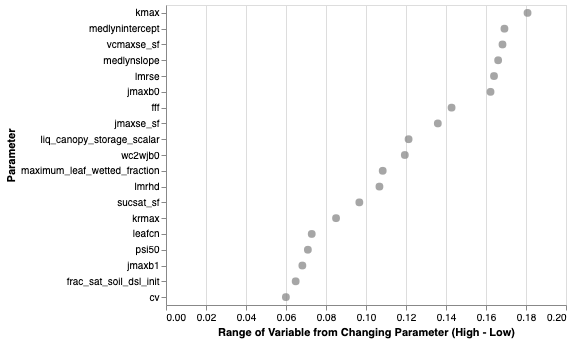

In [33]:
plot = base.transform_window(
    rank='rank(range)',
    sort=[alt.SortField('range', order='descending')]
).transform_filter(
    (alt.datum.rank < 20)
)

plot

# Combine min and max into new dataset

In [35]:
params_unique = np.unique(paramkey.param)
df = pd.DataFrame(data={'param': params_unique})
#df['category']=categories

In [36]:
for data_var in data_vars2:
    df[data_var+'_min']=np.nan
    df[data_var+'_max']=np.nan
    df[data_var+'_range']=np.nan

In [37]:
for v, data_var in enumerate(data_vars2):
    yind_min = df.columns.get_loc(data_var+"_min")
    yind_max = df.columns.get_loc(data_var+"_max")
    defaultval = paramkey[paramkey.minmax=='default'][data_var].values[0]
    for i, iparam in enumerate(paramkey.param[1:]):
        xind = df.index[(df.param==iparam)]
        if np.size(xind)!=1:
            print('error!')
        else:
            xind=xind.values[0]
        minval = paramkey[(paramkey.param==iparam)&(paramkey.minmax=='min')][data_var]
        maxval = paramkey[(paramkey.param==iparam)&(paramkey.minmax=='max')][data_var]
        if np.size(minval)>0:
            df.iat[xind,yind_min]=minval/defaultval
        if np.size(maxval)>0:
            df.iat[xind,yind_max]=maxval/defaultval

In [38]:
for v, data_var in enumerate(data_vars2):
    df[data_var+'_range']=np.abs(df[data_var+'_max']-df[data_var+'_min'])
    df[data_var+'_rank']=df[data_var+'_range'].rank(ascending=False)

In [39]:
df['total_rank'] = (df['albedo_allSW_rank']+
                    df['TSKIN_rank']+
                    df['FSH_rank']+
                    df['EFLX_LH_TOT_rank']+
                    df['TAUX_rank'])

df['total_rank'] = (np.where(df['albedo_allSW_rank']<=20, df['albedo_allSW_rank'],21)+
                    np.where(df['TSKIN_rank']<=20, df['TSKIN_rank'],21)+
                    np.where(df['FSH_rank']<=20, df['FSH_rank'],21)+
                    np.where(df['EFLX_LH_TOT_rank']<=20, df['EFLX_LH_TOT_rank'],21)+
                    np.where(df['TAUX_rank']<=20, df['TAUX_rank'],21))

In [40]:
source=df
base = alt.Chart(source).mark_circle(size=60).encode(
    x=alt.X('albedo_allSW_range'),
    y=alt.Y('alb_DirVis_range'),
    color='category',
    tooltip=['param'],
).interactive()

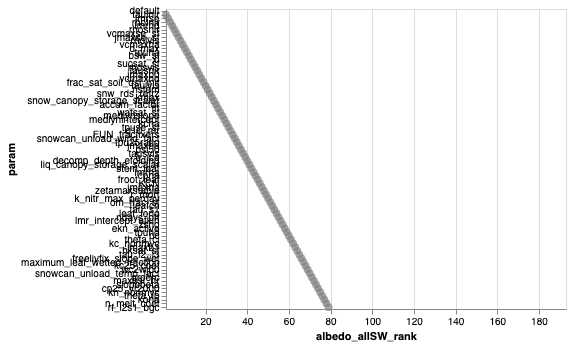

In [42]:
source=df
data_var='albedo_allSW_rank'
rangevals = alt.Chart(source).mark_circle(size=60,color='grey').encode(
    x=alt.X(data_var, scale=alt.Scale(domain=[np.nanmin(source[data_var]), np.nanmax(source[data_var])])),
    y=alt.Y('param',sort=alt.SortField(field=data_var, order='ascending')),
    #color='category',
    tooltip=['param',data_var],#'category',data_var],
)

# A dropdown filter
category_dropdown = alt.binding_select(options=list(np.unique(categories)))
category_select = alt.selection_single(fields=['category'], bind=category_dropdown, name="Category")

rangevals.transform_window(
    rank='rank('+data_var+')',
    sort=[alt.SortField(data_var, order='ascending')]
).transform_filter(
    (alt.datum.rank <= 80)
).add_selection(
category_select).transform_filter(category_select)

### Calculate weighted averages of ranges by variable type

In [91]:
df['albedo_range'] = (df['alb_DirVis_range']+df['alb_DirNIR_range']+
                      df['alb_DifVis_range']+df['alb_DifNIR_range']+df['FSA_range'])/5
df['momentum_range']=(df['TAUX_range']+df['TAUY_range']+df['U10_range'])/3
df['SH_range']=df['FSH_range']
df['moisture_range']=(df['EFLX_LH_TOT_range']+df['ET_range']+df['Q2M_range'])/3
df['temperature_range']=(df['TSA_range']+df['TSKIN_range']+df['FIRE_range'])/3

df['albedo_rank'] = (df['alb_DirVis_rank']+df['alb_DirNIR_rank']+
                      df['alb_DifVis_rank']+df['alb_DifNIR_rank']+df['FSA_rank'])/5
df['momentum_rank']=(df['TAUX_rank']+df['TAUY_rank']+df['U10_rank'])/3
df['SH_rank']=df['FSH_rank']
df['moisture_rank']=(df['EFLX_LH_TOT_rank']+df['ET_rank']+df['Q2M_rank'])/3
df['temperature_rank']=(df['TSA_rank']+df['TSKIN_rank']+df['FIRE_rank'])/3

In [92]:
df['total_range'] = (df['albedo_range']+df['momentum_range']+
                     df['SH_range']+df['moisture_range']+df['temperature_range'])/5

df['total_rank'] = (df['albedo_rank']+df['momentum_rank']+
                     df['SH_rank']+df['moisture_rank']+df['temperature_rank'])/5

In [93]:
df.sort_values('total_rank')

,param,category,FIRE_min,FIRE_max,FIRE_range,FSA_min,FSA_max,FSA_range,alb_DirVis_min,alb_DirVis_max,...,SH_range,moisture_range,temperature_range,albedo_rank,momentum_rank,SH_rank,moisture_rank,temperature_rank,total_range,total_rank
77,jmaxb0,Photosynthesis,1.004754,0.999618,0.005136,1.004760,0.998976,0.005784,1.082602,0.995577,...,0.151025,0.108571,0.002444,6.0,4.666667,4.0,14.333333,4.333333,0.098976,6.666667
100,lmrse,Plant BGC Cycling,0.999965,1.008646,0.008681,1.000849,0.998366,0.002483,0.996358,1.243239,...,0.075729,0.110483,0.003904,9.4,1.000000,15.0,8.000000,3.000000,0.115592,7.280000
181,vcmaxse_sf,Photosynthesis,1.000038,1.010509,0.010471,0.999673,1.015084,0.015411,1.003286,1.012746,...,0.136017,0.112842,0.004544,18.2,6.666667,5.0,9.333333,1.666667,0.080550,8.173333
107,medlynintercept,Plant Water Use / Hydraulics,1.000010,0.999171,0.000840,1.000006,1.001379,0.001373,0.999879,1.056058,...,0.180678,0.116536,0.000448,14.2,13.000000,3.0,2.333333,31.000000,0.096879,12.706667
183,wc2wjb0,Photosynthesis,1.002159,0.999638,0.002521,1.002744,0.998848,0.003896,1.028090,0.997575,...,0.124461,0.079682,0.001311,11.8,11.666667,7.0,27.666667,8.000000,0.061949,13.226667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,n_baseflow,Soil Hydrology,NaN,1.000056,NaN,NaN,0.999879,NaN,NaN,1.000552,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120,pc,Uncategorized,NaN,0.999936,NaN,NaN,0.999658,NaN,NaN,1.003257,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,rf_s2s1_bgc,Soil BGC Cycling,NaN,0.999996,NaN,NaN,1.000015,NaN,NaN,0.999365,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,theta_ip,Photosynthesis,NaN,0.999830,NaN,NaN,0.999870,NaN,NaN,0.996967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


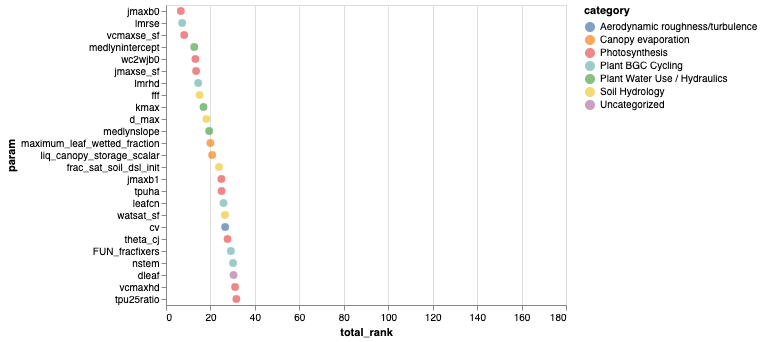

In [83]:
source=df
data_var='total_rank'
rangevals = alt.Chart(source).mark_circle(size=60,color='grey').encode(
    x=alt.X(data_var, scale=alt.Scale(domain=[np.nanmin(source[data_var]), np.nanmax(source[data_var])])),
    y=alt.Y('param',sort=alt.SortField(field=data_var, order='ascending')),
    color='category',
    tooltip=['param','category',data_var],
)

# A dropdown filter
category_dropdown = alt.binding_select(options=list(np.unique(categories)))
category_select = alt.selection_single(fields=['category'], bind=category_dropdown, name="Category")

rangevals.transform_window(
    rank='rank('+data_var+')',
    sort=[alt.SortField(data_var, order='ascending')]
).add_selection(
    category_select
).transform_filter(
    alt.datum.total_rank >0
).transform_filter(
    category_select
).transform_filter(
    (alt.datum.rank <= 40)
)

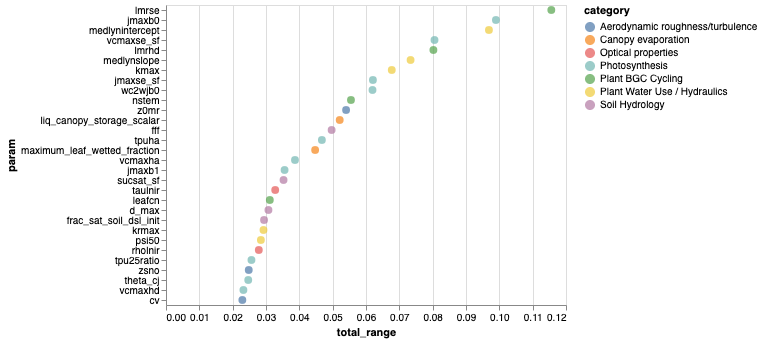

In [82]:
source=df
data_var='total_range'
rangevals = alt.Chart(source).mark_circle(size=60,color='grey').encode(
    x=alt.X(data_var, scale=alt.Scale(domain=[np.nanmin(source[data_var]), np.nanmax(source[data_var])])),
    y=alt.Y('param',sort=alt.SortField(field=data_var, order='descending')),
    color='category',
    tooltip=['param','category',data_var],
)

# A dropdown filter
category_dropdown = alt.binding_select(options=list(np.unique(categories)))
category_select = alt.selection_single(fields=['category'], bind=category_dropdown, name="Category")

rangevals.transform_window(
    rank='rank('+data_var+')',
    sort=[alt.SortField(data_var, order='descending')]
).add_selection(
    category_select
).transform_filter(
    alt.datum.total_rank >0
).transform_filter(
    category_select
).transform_filter(
    (alt.datum.rank <= 30)
)

In [31]:
df.to_csv('Test.csv')

### Top params by category:
* **Photosynthesis**
   * jmaxb0
   * vcmaxse_sf
   * jmaxse_sf
* **Other Plant BGC Cycling**
   * lmrse (note though that this affects stomatal conductance/photosynthesis)
   * lmrhd
   * nstem
* **Plant Water Use / Hydraulics**
   * medlynintercept
   * medlynslope
   * kmax
* **Soil Hydrology**
   * fff
   * sucsat_sf
   * d_max
* **Aerodynamic roughness/turbulence**
   * z0mr
   * zsno
   * cv
* **Optical Properties**
   * taulnir
   * rholnir
* **Canopy Evaporation**
   * liq_canopy_storage_scalar
   * maximum_leaf_wetted_fraction

### Make figure

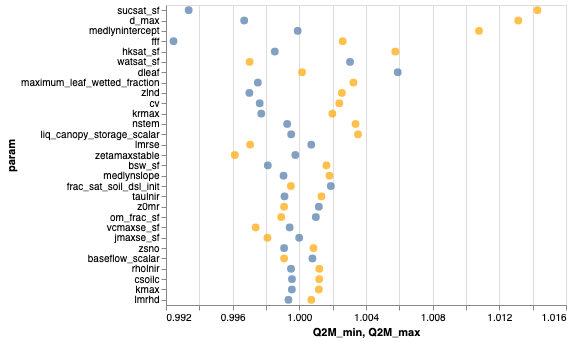

In [33]:
source = df
data_var = 'Q2M'
minvals = alt.Chart(source).mark_circle(size=60).encode(
    x=alt.X(data_var+'_min', scale=alt.Scale(domain=[np.nanmin(source[data_var+'_min']), np.nanmax(source[data_var+'_min'])])),
    y=alt.Y('param',sort=alt.SortField(field=data_var+'_range', order='descending')),
    tooltip=['param']
).interactive()

maxvals = alt.Chart(source).mark_circle(size=60,color='orange').encode(
    x=alt.X(data_var+'_max', scale=alt.Scale(domain=[np.nanmin(source[data_var+'_max']), np.nanmax(source[data_var+'_max'])])),
    y=alt.Y('param',sort=alt.SortField(field=data_var+'_range', order='descending')),
    tooltip=['param'],
).interactive()

(minvals+maxvals).transform_window(
    rank='rank('+data_var+'_range)',
    sort=[alt.SortField(data_var+'_range', order='descending')]
).transform_filter(
    (alt.datum.rank < 30)
)

In [245]:
df['rank_total'] = 0
for v, data_var in enumerate(data_vars2):
    df['rank_total'] = df['rank_total']+df[data_var+'_rank']

In [261]:
data_var='rank_total'
rangevals = alt.Chart(source).mark_circle(size=60,color='grey').encode(
    x=alt.X(data_var, scale=alt.Scale(domain=[np.nanmin(source[data_var]), np.nanmax(source[data_var])])),
    y=alt.Y('param',sort=alt.SortField(field=data_var, order='ascending')),
    tooltip=['param','rank_total','ET_rank'],
).interactive()

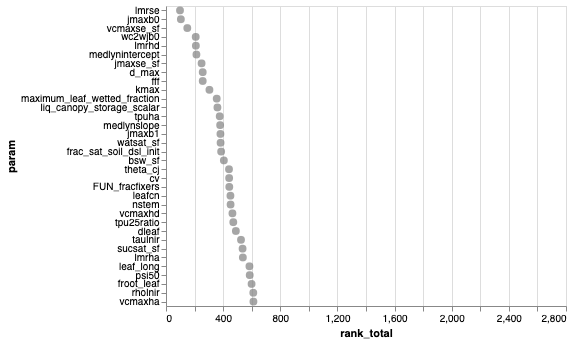

In [262]:
rangevals.transform_window(
    rank='rank('+data_var+'_range)',
    sort=[alt.SortField(data_var, order='ascending')]
).transform_filter(
    (alt.datum.rank_total>0)
).transform_filter(
    (alt.datum.rank < 50)
)

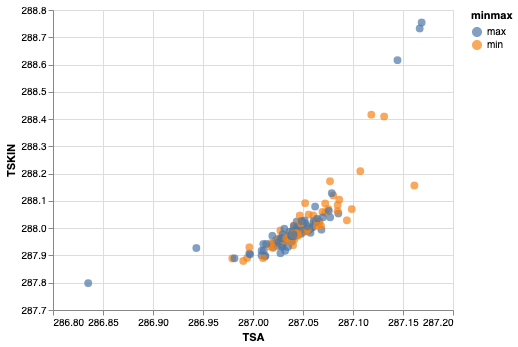

In [176]:
source = paramkey

alt.Chart(source).mark_circle(size=60).encode(
    x=alt.X('TSA', scale=alt.Scale(domain=[np.nanmin(source['TSA']), np.nanmax(source['TSA'])])),
    y=alt.Y('TSKIN', scale=alt.Scale(domain=[np.nanmin(source['TSKIN']), np.nanmax(source['TSKIN'])])),
    color='minmax',
    tooltip=['key', 'param', 'minmax']
).transform_filter(
    (datum.minmax != 'default')
).interactive()

# Other

In [66]:
uniques = np.unique(ds.param)
ix = uniques=='default'
uniques = uniques[~ix]

In [75]:
cts      = {u:0 for u in uniques}
ct_means = {u:0 for u in uniques}
ct_iavs  = {u:0 for u in uniques}

nx=20

for datavar in data_vars:
    print(datavar)
    if datavar=='ALTMAX':
        xm,xi = calc_alt(ds)
    else:
        xm,xa = calc_mean(ds,datavar)
        xi    = calc_iav(0,0,xa)

    plt.figure(figsize=[8,8])
    pm,pi = twoplots(ds,datavar,xm,xi,uniques)
    plt.savefig(datavar+'_top20.pdf')
    plt.close("all")
    
    for p in pm:
        cts[p]+=1
        ct_means[p]+=1

    for p in pi:
        cts[p]+=1
        ct_iavs[p]+=1

FIRE
FSA
FSDSVD
FSRVD
FSDSND
FSRND
FSDSVI
FSRVI
FSDSNI
FSRNI
EFLX_LH_TOT
FSH
QVEGT
QVEGE
QSOIL
TSA
TSKIN
Q2M
TAUX
TAUY
U10


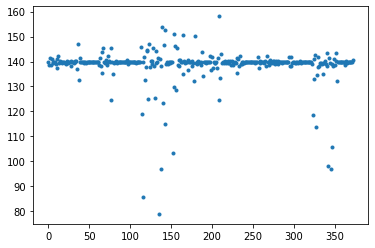

In [23]:
plt.plot(xm,'.')

In [ ]:
pcts=sorted(cts.items(), key=lambda item: item[1])
pvals=[];ct0=[];ct1=[]
for p,x in pcts:
    
    if x==0:
        pvals.append(p)
        ct0.append(ct_means[p])
        ct1.append(ct_iavs[p])
    else:
        pvals.insert(0,p)
        ct0.insert(0,ct_means[p])
        ct1.insert(0,ct_iavs[p])
    
ct_table = pd.DataFrame({'param':pvals,'mean':ct0,'iav':ct1})
ct_table.to_html(buf='top20_summary.html')